<a href="https://colab.research.google.com/github/graf10a/Blackboard-grade-calculator/blob/master/03_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Linear Regression Example: Auto MPG Data Set

### Mounting the Google Drive

When working with Colab notebooks you will often need to access data stored on your Google Drive. To get access to this data you must first mount your Google Drive. To do that follow these simple steps:

1. Import the `drive` utility by running `from google.colab import drive`
2. Run `drive.mount(/content/gdrive)`. 
3. You will see the output shown below. Click on the link.

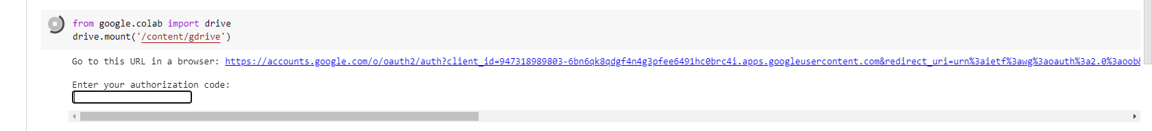

4. Clicking of the link will open a new tab in your browser. Click on your Google account icon (if you have more than one Google account then you will have to decide which one of them you want to mount to your Colab notebook).

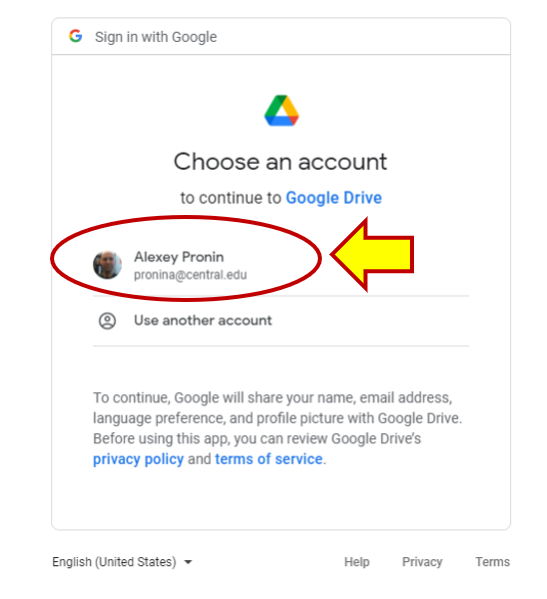

5. On the next screen, click the "Allow" button located in the bottom right corner.

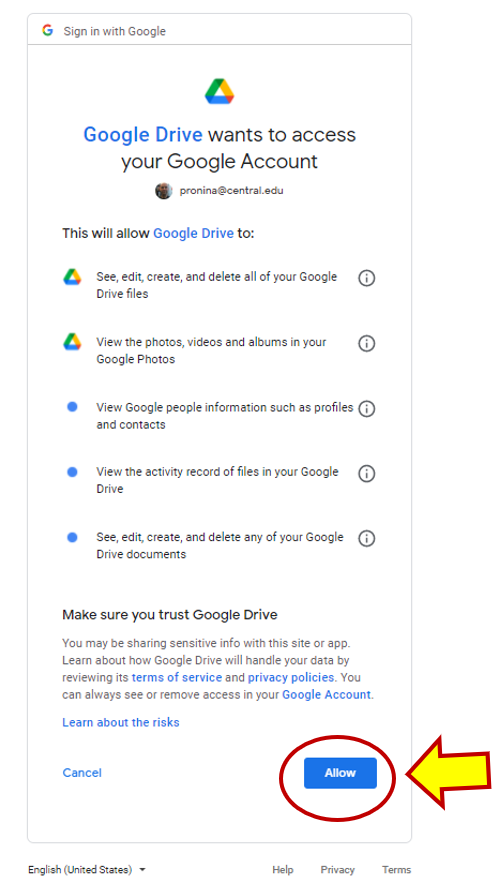

6. Next, you will be given a security code. Copy this code to the clipboard by clicking on the icon located on the right side of the code that looks like two pages placed on top of one another. 

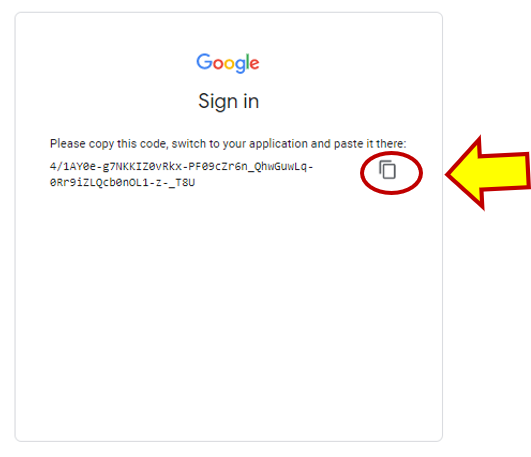

7. Go back to your Colab notebook, paste the security code into the provided space, and hit the ENTER button. This should complete the process.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Loading Libraries and Data

We will need to load the NumPy library to work with NumPy arrays. In addition, we are going to import the `Path` function from the Python built-in `pathlib` library.

In [ ]:
import numpy as np
from pathlib import Path

The root directory of my (and yours) Google Drive has the following path: `/content/gdrive/My Drive/`. The full path to the data that we need to access looks like this:

In [ ]:
PATH = Path('/content/gdrive/My Drive/Colab Notebooks/Applied_Machine_Learning/Data/Auto_MPG')

Note that we are using the `Path` function to create this path. In principle, we could have just creates a simple string storing this path but then we would need to remember to change this path if we ever decide to run our notebook on a Windows computers -- in Windows, when building a full filename that includes the complete path we separate different directories and the file name with backslashes while on Linux computers we use forward slashes. The `Path` function takes care of this problem for us -- it automatically adjusts our path depending on the type of our operating system. This way our code becomes more portable which is a good thing! 

To illustrate the main ideas of *linear regression* we will be using a famous *Auto MPG* data set which is freely available for download from the  [University of California Irvine (UCI) Machine Learing Repository](https://archive.ics.uci.edu/ml/datasets/auto+mpg). The dataset holds information about the characteristics of many different cars that where manufactured in the US, Europe, and Japan from 1970 to 1982. These characteristics include the weights of the cars, their city-cycle fuel consumption in miles per gallon, accelerations, the numbers of cyclinders, the place of origin, etc. In what follows we will be focusing on two of these characterisitcs which we will load as NumPy arrays (note how we added the filenames to the `PATH` vairable to create the full paths to the files):

In [ ]:
hp = np.load(PATH/'horsepower.npy')
dis = np.load(PATH/'displacement.npy')

The `hp` array holds information about the power output of various cars in horse powers and the `dis` array holds information about the engine displacements of the cars. By the way, if you don't know what *engine displacement* is please read the following definition from a [Wikipidea article](https://en.wikipedia.org/wiki/Engine_displacement):

*Engine displacement* is the measure of the cylinder volume swept by all of the pistons of a piston engine, excluding the combustion chambers. It is commonly used as an expression of an engine's size, and by extension as a loose indicator of the power an engine might be capable of producing and the amount of fuel it should be expected to consume.

Based on this definition, it is reasonable to expect that the engine displacements and the power outputs must be somehow related to one another. In what follows we will try to explore this relation. But first of all, let's take a quick look at the data:

In [ ]:
print(dis.shape)
print(hp.shape)

(398,)
(398,)


### Data visualization

It looks like we have information about horseposers and displacements of 398 cars! Let's create a simple two-dimensional plot of these variables to get a better idea about how they are related to one another. We will be treating the displacement as our independent variable and plot it on the horizontal axis. The horsepower will be treated as a dependent variable; we will plot it on the vertical axis.

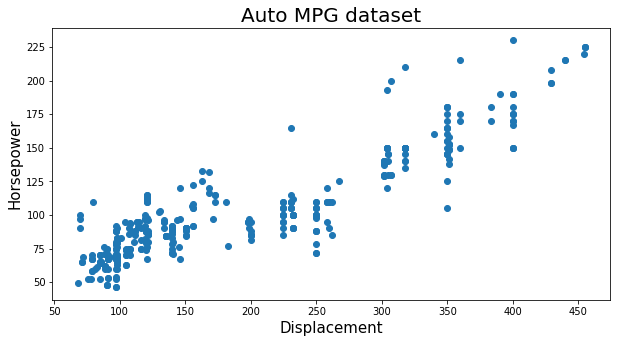

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure(figsize=(10, 5))
plt.plot(dis, hp, 'o')
plt.xlabel("Displacement", fontsize=15)
plt.ylabel("Horsepower", fontsize=15)
plt.title("Auto MPG dataset", fontsize=20)
plt.show()

Yes, it looks like these variables are related to each other. Also, we can try fitting these data points with a straight line -- it seems to be a reasonable choice here. 

Let's assume that the equation describing the straight line that fits our data in the best possible way looks like this: $y = \hat\theta_1 x + \hat\theta_0$, where $x$ and $y$ are the displacement and the horsepower variables, respectively, $\hat\theta_1$ is the slope, and $\hat\theta_0$ is the vertical intercept of the line. Finding this line is equivaluent to building a simple machine learning model that allows us to predict the value of the dependent variable (horsepower)  for any given value of the independent variable (displacement). 

By the way, in machine learning, independent variable are often called *features* and the dependent variable is called *target*; the numerical values of the target are often called *labels*. In light of what we just learned, we can say that features are our input variables and labels are the things we are predicting. In our example, there is only one feature, the engine's displacement, and our target here is the horsepower output of the engine.

### Missing values

But before we move any further, let's take a look at the following slice of the `hp` data:

In [ ]:
print(hp[330:340])

[ nan  67.  62. 132. 100.  88.  nan  72.  84.  84.]


What does `nan` stand for? `nan` means *not a number* in Python. This is an example of missing data -- the corresponding value of the horsepower is not available. There might be various reasons for that. It is possible that this value was never recorded in the first place, or maybe this entry was somehow corrupted: trying to compute  a square root of a negtive number or to divide a number by zero will lead to the `nan` output. Anyway, but before proceeding any further, we need to do something with the missing data. At this point we will adopt the simplest possible method for dealing with missing values -- we will simple remove the corresponding entries from our data set. But this is not the only viable route -- in some cases you might want to try filling the missing values. We will talk about it later. 

To remove the missing values we will first need to find them. In NumPy, this can be done with the `np.isnan()` function:

In [ ]:
mask_hp=np.isnan(hp)
mask_dis=np.isnan(dis)

This function returns a boolean mask that has `True` for `nan` values and `False` for all others.  

How many missing values do we have?

In [ ]:
print(np.count_nonzero(mask_hp))
print(np.count_nonzero(mask_dis))

6
0


6 missing values in the horsepower data and not missing values in the engine displacement data. Good! Now let's use the boolean mask `mask_hp` to remove the missing values (we need to remove them from both `hp` and `dis`).

In [ ]:
hp_no_nan = hp[~mask_hp]
dis_no_nan = dis[~mask_hp]

print(hp_no_nan.shape, dis_no_nan.shape)

(392,) (392,)


We have only 392 data point left. Let's make sure that there are no missing values:

In [ ]:
print(np.isnan(hp_no_nan).sum())
print(np.isnan(dis_no_nan).sum())

0
0


### Least Squares Fitting

Now the question becomes how to we find a straight line that fits our data points in the best possible way? We will be using the method of least-squares to find this line. To understand how this methods works, we need to develop a criterion for evaluating the quality of our fit. Let's begin by picking some arbitrary straight line -- this line does not have to fit our data particularly well. The line is defined by its slope $\theta_1$ and vertical intercept $\theta_0$; the line equation is $y=\theta_1 x + \theta_0$. For any $x$-value this equation *predicts* the corresponding $y$-value. Now, for every data point we measure the vertical distance from the data point to the line -- this distance is called the absolute value of the *residual* (residual = observed - predicted). The graph below illustrates this idea: the residuals are shown there with red vertical lines.

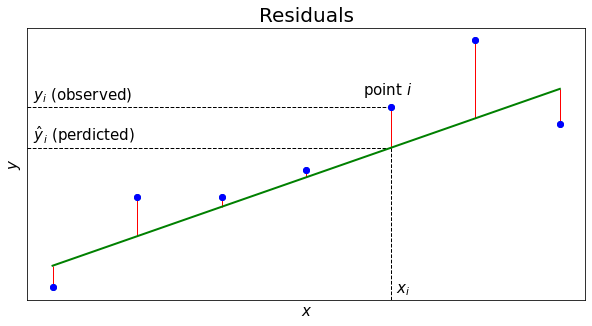

In [ ]:
plt.figure(figsize=(10, 5))
n=7
th_1=0.4
th_0=0.1
x = np.linspace(0, 9, n)
y_pred = th_1*x + th_0 
np.random.seed(1429)
y = y_pred + np.random.normal(size=len(y_pred))
plt.plot(x, y, 'o')
ax = plt.gca()
i=4
x_min = plt.gca().get_xlim()[0]
x_max = plt.gca().get_xlim()[1]
y_min = plt.gca().get_ylim()[0]
y_max = plt.gca().get_ylim()[1]
plt.axhline(y=y[i], xmin=0, xmax=(x[i] - x_min)/(x_max - x_min), 
            ls='--', color='black', lw=1.0)
plt.axhline(y=y_pred[i], xmin=0, xmax=(x[i] - x_min)/(x_max - x_min), 
            ls='--', color='black', lw=1.0)
plt.axvline(x=x[i], ymin=0, ymax=(y_pred[i] - y_min)/(y_max - y_min), 
            ls='--', color='black', lw=1.0)
plt.plot(x, y, 'o', color='blue')
plt.plot(x, y_pred, color='green', lw=2.0)
plt.vlines(x, y_pred, y, colors='red', lw=1.0)
plt.text(x[i] - 0.5, y[i] + 0.25, r'point $i$', fontsize=15)
plt.text(x[i]+0.1, -0.45, r'$x_i$', fontsize=15)
plt.text(-0.35, y[i]+0.15, r'$y_i$ (observed)', fontsize=15)
plt.text(-0.35, y_pred[i]+0.15, r'$\hat y_i$ (perdicted)', fontsize=15)
plt.xlabel(r"$x$", fontsize=15)
plt.ylabel(r"$y$", fontsize=15)
plt.title("Residuals", fontsize=20)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
plt.show()

Next, let's compute the average of the squares of the residuals. The resulting object is called the *mean squared error* function in statistics (or the $\text{MSE}$ function, for short):

$$
\text{MSE} = \frac{1}{m}\sum\limits_{i=1}^{m}(y_i - \hat y_i)^2\;,
$$

where $m$ is the total number of the data points, $y_i$ (the observed value) is the vertical coordinates of the $i^{\text{th}}$ data points while $\hat y_i$ (the predicted value) is the vertical coordinates of the point on the line located either straight above or straight below $y_i$.

By definition, the *best fit line* is the line that has the smallest possible $
\text{MSE}$ and the main task of linear regression is to find this line. This approach is know as *least squres fitting*. More generally, the $\text{MSE}$ function defined above gives a great example of a so-called *loss function*. Many machine learning algorithms have the goal of minimizing some particular loss function as their primary objective. The mathematical form of the loss function is specific to the machine learning problem at hand: regression is just one example of such a problem and later we will see many others. But the general idea will remain the same: we will be using loss functions to estimate the quality of our predictive models; the smaller the loss function the better the model.

Substituting the line equation $\hat y_i = \theta_1 x_i + \theta_0$ into the formula for $\text{MSE}$ yields:

$$
\text{MSE} = \sum\limits_{i=1}^{N}(y_i - \theta_1 x_i - \theta_0)^2\;.
$$

We see that $\text{MSE}$ can be thought of as a function of two variables, $\theta_1$ and $\theta_0$. By changing the values of these variables we change RSS and we change the line. To find the best fit line we need to find the values of $\theta_1$ and $\theta_0$ that minimize RSS. We will call these values $\hat\theta_1$ and $\hat\theta_0$ -- these are the slope and the vertical intercept of the best fit line.

In principle, the problem of finding $\hat\theta_1$ and $\hat\theta_0$ can be solved analytically -- the solution is known as the *normal equation*. As a matter of fact, the normal equation formula can be applied for any number of independent variables (or features), not just one. In our class, we won't be going in this direction though. It turns out that there are alternative itterative optimization methods of finding the solution and, in some situations, these methods have a computational and conceptual advantage over the analytical solution. In our class, we will be using a *gradient descent* method to find the best fit line in the linear regression problem.

To understand the main idea of gradient descent, let's simplify our problem a bit by assuming that the vertical intercept $\hat\theta_0$ is zero. In doing so, we are forcing our bet fit line to pass through the origin of our coordinate system. This makes sense on physical ground -- zero displacement means that the engine's piston does not sweep out any of the engine's volume at all, so there is no reason to expect that such an engine will produce any power output. Of course this argument is not completely bulletproof: after all, we are trying to fit the data for hunderds of different cars, so there might be other factors involved that can potentially push the value of the vertical intercept away from zero. But setting it to zero seems like a reasonable starting point. 

If $\hat\theta_0$ is known to be zero then our problem of finding the best fit line reduces to finding a single parameter, the slope of the line $\hat\theta_1$. To find it, we need to minimize $\text{MSE}$. As a first step, let's plot $\text{MSE}$ as a function of $\theta_1$. To do that, we first need to create an evenly spaced array of the slope values. This can be acomplished with the help of a NumPy `np.linspace` function.


In [ ]:
theta_1 = np.linspace(0, 1, 101)
# theta_1

A function for computing $\text{MSE}$:

In [ ]:
def compute_mse(slope, y=hp_no_nan, x=dis_no_nan):
    """
        Purpose:
            Compute the residual sum of squares, 
            assuming that the best fit line passes
            through the origin.
        Parameters:
            slope - the slope of the fit line.
    """
    
    return ((y - slope*x)**2).mean()

Here are the corresponding values of $\text{MSE}$:

In [ ]:
mse = np.array([compute_mse(slope) for slope in theta_1])
# mse

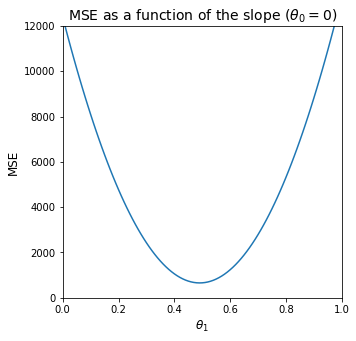

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(theta_1, mse)
plt.xlabel(r"$\theta_1$", fontsize=12)
plt.ylabel("MSE", fontsize=12)
plt.xlim(0, 1)
plt.ylim(0, 12000)
plt.title(r"MSE as a function of the slope ($\theta_0 = 0$)", fontsize=14)
plt.show()

We observe that the  function is a parabola that has a minimum somewhere around $\theta_1 = 0.5$. To find the point of minimum more accurately, we will utilaze an iterrative procedure. We will start with some arbitrary value of the slope picked from the interval $[0, 1]$.


In [ ]:
np.random.seed(142)

slope=np.random.rand()
print(f"The initial value of the slope is {slope:.5f}.")

The initial value of the slope is 0.90206.


Let's show our starting point on the graph above:

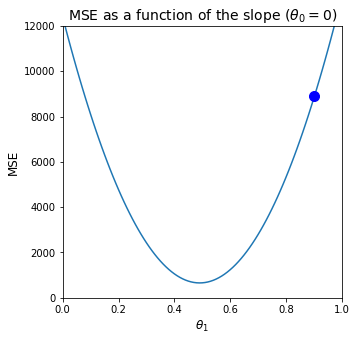

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(theta_1, mse)
plt.plot(slope, compute_mse(slope), 'o', color='blue', ms=10)
plt.xlabel(r"$\theta_1$", fontsize=12)
plt.ylabel("MSE", fontsize=12)
plt.xlim(0, 1)
plt.ylim(0, 12000)
plt.title(r"MSE as a function of the slope ($\theta_0 = 0$)", fontsize=14)
plt.show()

Our initial location on the $\text{MSE}$ graph is marked with a blue dot and it is clear that currently, we are sitting pretty far away from the minimum. We need to update the value of $\theta_1$ to get closer to the minimum. But how should we do that? Do we need to increase or decrease $\theta_1$? By how much? 

The picture above shows that, in our example, we need to make $\theta_1$ smaller because currently we are sitting on the right side from the minimum. Had we been on the left side, we would have to increase the value of $\theta_1$. Note that the $\text{MSE}$ function shown in the picture has a positive slope on the right side from the minimum and a negative slope otherwise. The slope is nothing but the derivative of the $\text{MSE}(\theta_1)$ function. This suggests that the value of $\theta_1$ can be updated as follows:

$$
(\theta_1)_{\text{new}} = \theta_1 - \eta \cdot \frac{d \text{MSE}(\theta_1)}{d \theta_1}\;,
$$

where $\eta$ is a positive parameter called the *learning rate* that controls the size of the update. You should easily convince yourself that the update formula makes sense. For example, when we are on the right side from the minimum the derivative is positive, so that the new value of the slope comes out to be smaller that the old one -- we are moving to the left along the horizontal axis and getting closer to the minimum. 

Using the standard rules of calculus, one can easily compute the derivative:

$$
\text{MSE} = \frac{1}{m}\sum\limits_{i=1}^{m}(y_i - \theta_1 x_i)^2\quad\Longrightarrow \quad \frac{d \text{MSE}(\theta_1)}{d \theta_1} = \frac{1}{m}\sum\limits_{i=1}^{m}2(y_i - \theta_1 x_i)(-x_i)
$$

$$
\frac{d \text{MSE}(\theta_1)}{d \theta_1} = -\frac{2}{m}\sum\limits_{i=1}^{m}(x_iy_i - \theta_1 x_i^2)\;.
$$

Let's now demonstrate how this update works with some specific value of the learning rate $\eta$.

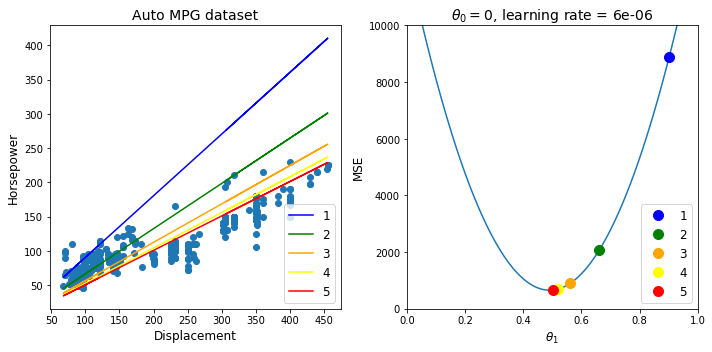

In [ ]:
np.random.seed(142)
slope=np.random.rand()
colors=['blue', 'green', 'orange', 'yellow', 'red']
lr = 0.000006 # learning rate
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(dis_no_nan, hp_no_nan, 'o')
ax[0].set_xlabel("Displacement", fontsize=12)
ax[0].set_ylabel("Horsepower", fontsize=12)
ax[0].set_title("Auto MPG dataset", fontsize=14)
ax[1].plot(theta_1, mse)
ax[1].set_xlabel(r"$\theta_1$", fontsize=12)
ax[1].set_ylabel("MSE", fontsize=12)
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 10000)
# ax[1].set_title("MSE vs the slope; " + r"$\theta_0 = 0$" + f", learning rate = {lr}", fontsize=14)
ax[1].set_title(r"$\theta_0 = 0$" + f", learning rate = {lr}", fontsize=14)
for i, col in enumerate(colors, 1):   
    hp_pred = slope*dis_no_nan    
    ax[0].plot(dis_no_nan, hp_pred, color=col, label=i)
    ax[1].plot(slope, compute_mse(slope), 'o', color=colors[i-1], ms=10, label=i)
    slope = slope - 2*(-1)*((hp_no_nan-hp_pred)*dis_no_nan).mean()*lr
ax[0].legend(loc='lower right',fontsize=12)
ax[1].legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.show()

As you see, after just 5 interrations we got pretty close to the minimum! 

In [ ]:
print(f"After 5 interations the slope is {slope:.5f}.")

After 5 interations the slope is 0.49596.


How good is this result? Well, in this simple case we can find the slope of the best fit line directly by setting the derivative of the $\text{MSE}$ function computed above to zero.
$$
\left. \frac{d \text{MSE}(\theta_1)}{d \theta_1} \right|_{\theta_1=\hat\theta_1} = 0\quad\Longrightarrow\quad -\frac{2}{m}\sum\limits_{i=1}^{m}(x_iy_i - \hat\theta_1 x_i^2) = 0\;,
$$

$$
\sum\limits_{i=1}^{m}(x_iy_i) - \hat\theta_1 \sum\limits_{i=1}^{m}(x_i^2) = 0\quad\Longrightarrow\quad\hat\theta_1 = \sum\limits_{i=1}^{m}(x_iy_i)/ \sum\limits_{i=1}^{m}(x_i^2)\;.
$$

Substituting `dis_no_nan` for the $x$-values and `hp_no_nan` for the $y$-values yields:

In [ ]:
slope_theor = (dis_no_nan*hp_no_nan).sum() / (dis_no_nan**2).sum()
print(f"The theoretical value of the slope is {slope_theor:.5f}.")
print(f"The percent deviation is {abs(slope-slope_theor)/slope_theor*100:.5f} per cent.")

The theoretical value of the slope is 0.49088.
The percent deviation is 1.03581 per cent.


After five steps of gradient descent we are just about one per cent away from the true minimum. Not bad! The process of finding the optimal value of the slope is called *training* -- we train our gradient descent algorithm by feeding it the data and find the optimal value of the slope. We say that the slope in this example is a *trainable* parameter because its value can be learned by the algorithm.

### Learning rate

At the same time, it is very important to remember to choose the learning rate wisely. The next picture illustrate what happens in two extreme cases: when the learning rate is too low and when it is too high. 

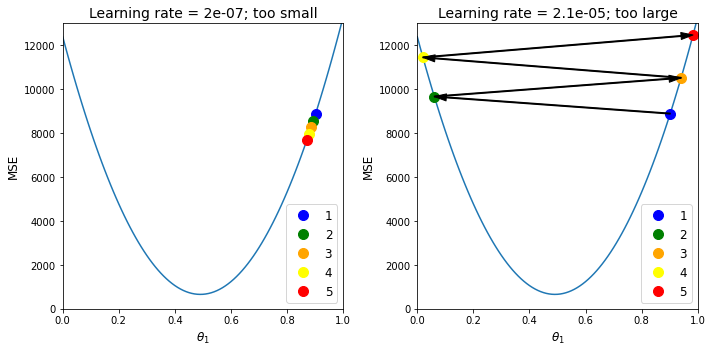

In [ ]:
np.random.seed(142)
slope_1=np.random.rand()
np.random.seed(142)
slope_2=np.random.rand()
colors=['blue', 'green', 'orange', 'yellow', 'red']
lr_1 = 0.0000002 # small learning rate
lr_2 = 0.000021 # large learning rate
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(theta_1, mse)
ax[0].set_xlabel(r"$\theta_1$", fontsize=12)
ax[0].set_ylabel("MSE", fontsize=12)
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 13000)
ax[0].set_title(f"Learning rate = {lr_1}; too small", fontsize=14)
ax[1].plot(theta_1, mse)
ax[1].set_xlabel(r"$\theta_1$", fontsize=12)
ax[1].set_ylabel("MSE", fontsize=12)
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 13000)
ax[1].set_title(f"Learning rate = {lr_2}; too large", fontsize=14)
for i, col in enumerate(colors, 1):    
    ax[0].plot(slope_1, compute_mse(slope_1), 'o', color=colors[i-1], ms=10, label=i)
    ax[1].plot(slope_2, compute_mse(slope_2), 'o', color=colors[i-1], ms=10, label=i)
    if i > 1:
      ax[1].annotate("", xy=(slope_2, compute_mse(slope_2)), xytext=(slope_2_old, compute_mse(slope_2_old)), arrowprops=dict(headwidth=7, width=1, color='black'))      
    slope_2_old = slope_2
    hp_pred_1 = slope_1*dis_no_nan 
    hp_pred_2 = slope_2*dis_no_nan
    slope_1 = slope_1 - 2*(-1)*((hp_no_nan-hp_pred_1)*dis_no_nan).mean()*lr_1
    slope_2 = slope_2 - 2*(-1)*((hp_no_nan-hp_pred_2)*dis_no_nan).mean()*lr_2
ax[0].legend(loc='lower right',fontsize=12)
ax[1].legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.show()

In both cases, gradient descent is having a very hard time to converge to the minimum. If the learning rate is too low, it will take a very large number of steps to reach the minimum. On the other hand, with a high learning rate, one can easily miss the minimum. As a matter of fact, if the learning rate is too high (the right graph), every new update pushes us farther and farther away from the minimum. At the very first step, the update of $\theta_1$ is so large that we end up on the opposite site from the minimum, at a point lying higher on the $\text{MSE}$ curve (the green dot) than the initial point (the blue dot). At this higher location the parabola has a steeper slope (in the absolute value sense, of course), so the next update overshoots even more -- the orange point is located even higher on the parabola. And so far and on -- the algorithm will never converge to the minimum, it will be constantly running away from it.

The optimal value of the learning rate cannot be obtained from gradient descent -- it is usually determined through trials and errors. In machine learning we use a special term for *non-trainable* parameters whose values must be set by hand (e.g the learning rate) -- we call them *hyperparameters*. Gradient descent is a very simple algorithm and it has only one hyperparameter but later we will examples of learning algorithms with a much larger number of hyperparameters.

### Adding the vertical intercept

What if we abandon the assumption that the vertical intercept must always be equal to zero? How do we minimize the $\text{MSE}$ function in this case, when there are two rather than one trainable parameters? It turns out that we can still use the gradient descent method. The main idea of the method remains the same -- at each step we update the old values of $\theta_1$ and $\theta_0$ in the way that gets us closer to the minimum of the $\text{MSE}$ function.

In [ ]:
def compute_mse_2(v_int, slope, y=hp_no_nan, x=dis_no_nan):
    """
        Purpose:
            Compute the residual sum of squares, 
            assuming that the best fit line passes
            through the origin.
        Parameters:
            slope - the slope of the fit line.
    """
    return ((y.reshape(-1, 1, 1) - slope*x.reshape(-1, 1, 1) - v_int)**2).mean(axis=0)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


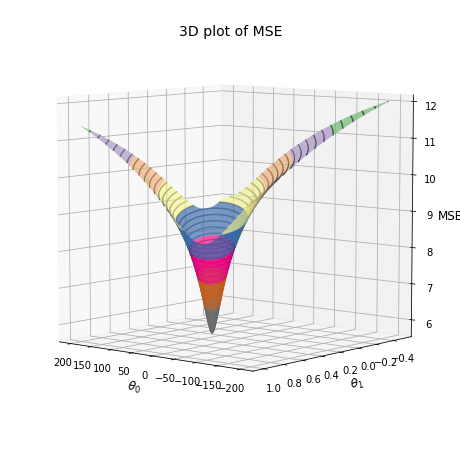

In [ ]:
from mpl_toolkits import mplot3d
n=500
theta_0 = np.linspace(-200, 200, n)
theta_1 = np.linspace(-0.5, 1, n)
X, Y = np.meshgrid(theta_0, theta_1)
Z = np.log(compute_mse_2(X, Y))
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='Accent_r', edgecolor='none')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel(r'$\theta_0$', fontsize=12)
ax.set_ylabel(r'$\theta_1$', fontsize=12)
ax.set_zlabel('MSE', fontsize=12)
ax.set_title("3D plot of MSE", 
             fontsize=14)
ax.view_init(7, 130)
plt.show()

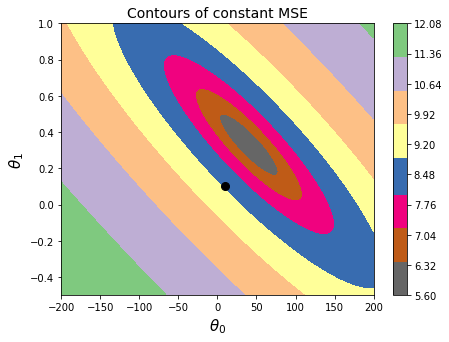

In [ ]:
slope=0.1
v_int=10
plt.figure(figsize=(7, 5))
plt.contourf(X, Y, Z, 100, cmap='Accent_r')#'RdGy')
plt.plot(v_int, slope, 'o', color='black', ms=8)
plt.colorbar()
plt.xlabel(r"$\theta_0$", fontsize=15)
plt.ylabel(r"$\theta_1$", fontsize=15)
plt.title("Contours of constant MSE", fontsize=14)
plt.show()

The graph above shows the contours of constant $\text{MSE}$. The values of the vertical intercept and the slope are plotted on the horizontal and vertical axes, respectively and different colors represent different values of $\text{MSE}$, from grey (low) to green (high). We can start the gradient descent algorithm by initializing $\theta_0$ and $\theta_1$ with some arbitrary values. Let's say, that we start at the location of the black dot shown on the graph. The main idea of gradient descent is that in order to get closer to the minimum we need to move in the direction of fastest decrease of the  $\text{MSE}$ function. This direction is given by the negative *gradient* of the function, $-\nabla\text{MSE}$. The $\theta_0$ and $\theta_1$ components of the gradient are

$$
\nabla\text{MSE}(\theta_0, \theta_1) = \begin{pmatrix}\displaystyle \frac{\partial \text{MSE}(\theta_0, \theta_1)}{\partial \theta_0} \\ \displaystyle \frac{\partial \text{MSE}(\theta_0, \theta_1)}{\partial \theta_1}\end{pmatrix}
$$

The update equations become:

$$
(\theta_0)_{\text{new}} = \theta_0 - \eta \cdot \frac{\partial \text{MSE}(\theta_0, \theta_1)}{\partial \theta_0}\;.
$$

$$
(\theta_1)_{\text{new}} = \theta_1 - \eta \cdot \frac{\partial \text{MSE}(\theta_0, \theta_1)}{\partial \theta_1}\;.
$$

The partial derivatives can be computed explicitly:

$$
\text{MSE}(\theta_0, \theta_1) = \frac{1}{m}\sum\limits_{i=1}^{m}(y_i - \theta_1 x_i - \theta_0)^2
$$

$$
\frac{\partial \text{MSE}(\theta_0, \theta_1)}{\partial \theta_0} = -\frac{2}{m}\sum\limits_{i=1}^{m}(y_i - \theta_1 x_i - \theta_0)
$$

$$
\frac{\partial \text{MSE}(\theta_0, \theta_1)}{\partial \theta_1} = -\frac{2}{m}\sum\limits_{i=1}^{m}(y_i - \theta_1 x_i - \theta_0)x_i
$$

Let's see how this procedure is going to work on our horsepower and displacement data.

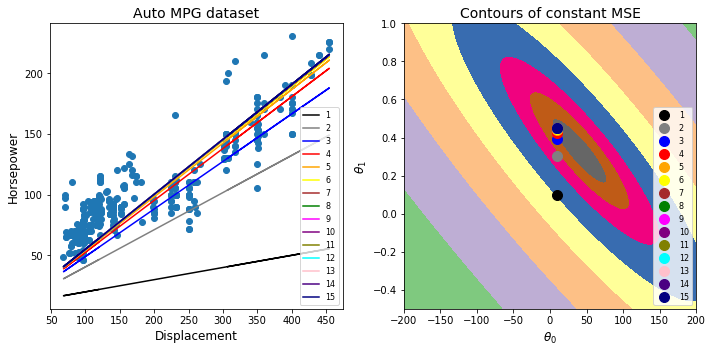

In [ ]:
slope=0.1
v_int=10
colors=['black', 'gray', 'blue','red', 'orange', 'yellow', 'brown', 'green', 
        'magenta', 'purple', 'olive', 'cyan', 'pink', 'indigo', 'navy']
lr = 0.000006 # learning rate
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(dis_no_nan, hp_no_nan, 'o')
ax[0].set_xlabel("Displacement", fontsize=12)
ax[0].set_ylabel("Horsepower", fontsize=12)
ax[0].set_title("Auto MPG dataset", fontsize=14)
ax[1].contourf(X, Y, Z, 100, cmap='Accent_r')#'RdGy')
ax[1].set_xlabel(r"$\theta_0$", fontsize=12)
ax[1].set_ylabel(r"$\theta_1$", fontsize=12)
plt.title("Contours of constant MSE", fontsize=14)
for i, col in enumerate(colors, 1):   
    hp_pred = slope*dis_no_nan + v_int
    ax[0].plot(dis_no_nan, hp_pred, color=col, label=i)
    ax[1].plot(v_int, slope, 'o', color=colors[i-1], ms=10, label=i)
    slope = slope - 2*(-1)*((hp_no_nan-hp_pred)*dis_no_nan).mean()*lr
    v_int = v_int - 2*(-1)*(hp_no_nan-hp_pred).mean()*lr#*25_000
ax[0].legend(loc='lower right',fontsize=8)
ax[1].legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.show()

The picture on the right shows that our procedure does not work very well -- the convergence toward the minimum (the center of the elipses) happens very slowly in the $\theta_0$ direction. It happened because for the data set at hand the slope and the vertical intercept have very different scales, so they converge at different rates. One way to remedy this problem is to use two different learning rates: one for the slope and another for the vertical intercept. But it is not convenient because if we do that we will have to tune two learning rate hyperparameters instead of just one. Usually, it is a much better idea to re-scale your feature variable before doing gradient descent. For example, we can rescale our displacement data in such a way that all values are going to be in the $[0, 1]$ range. This can be done as follows: 

In [ ]:
dis_no_nan_scaled = (dis_no_nan - dis_no_nan.min())/(dis_no_nan.max() - dis_no_nan.min())

We just subtracted out the smallest value of the displament and divided the result by the size of the gap between the largest and the smallest values of the displacement. This brings our data within the $[0, 1]$ range:

In [ ]:
print(f"The minimum value in the re-scaled displacement data is {dis_no_nan_scaled.min()}.")
print(f"The maximum value in the re-scaled displacement data is {dis_no_nan_scaled.max()}.")

The minimum value in the re-scaled displacement data is 0.0.
The maximum value in the re-scaled displacement data is 1.0.


Let's try to perform gradient descent on the re-scalled data:

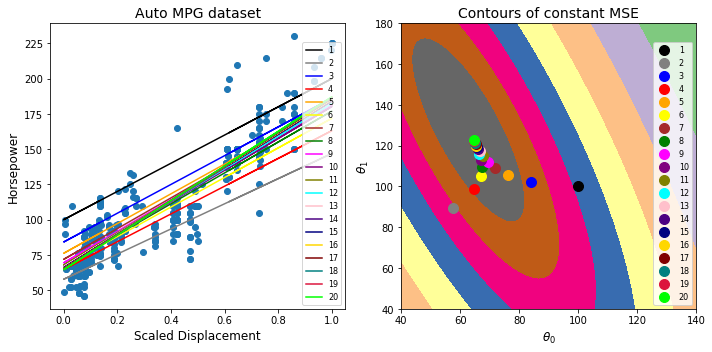

In [ ]:
slope=100
v_int=100
dis_no_nan_scaled = (dis_no_nan - dis_no_nan.min())/(dis_no_nan.max() - dis_no_nan.min())
n_scaled=100
theta_0_scaled = np.linspace(40, 140.0, n_scaled)
theta_1_scaled = np.linspace(40, 180.0, n_scaled)
X_scaled, Y_scaled = np.meshgrid(theta_0_scaled, theta_1_scaled)
Z_scaled = np.log(compute_mse_2(X_scaled, Y_scaled, x=dis_no_nan_scaled))
colors=['black', 'gray', 'blue','red', 'orange', 'yellow', 'brown', 'green', 
        'magenta', 'purple', 'olive', 'cyan', 'pink', 'indigo', 'navy', 'gold', 
        'maroon', 'teal', 'crimson', 'lime']
lr = 0.75 # learning rate
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(dis_no_nan_scaled, hp_no_nan, 'o')
ax[0].set_xlabel("Scaled Displacement", fontsize=12)
ax[0].set_ylabel("Horsepower", fontsize=12)
ax[0].set_title("Auto MPG dataset", fontsize=14)
ax[1].contourf(X_scaled, Y_scaled, Z_scaled, 100, cmap='Accent_r')#'RdGy')
ax[1].set_xlabel(r"$\theta_0$", fontsize=12)
ax[1].set_ylabel(r"$\theta_1$", fontsize=12)
plt.title("Contours of constant MSE", fontsize=14)
for i, col in enumerate(colors, 1):   
    hp_pred = slope*dis_no_nan_scaled + v_int
    ax[0].plot(dis_no_nan_scaled, hp_pred, color=col, label=i)
    ax[1].plot(v_int, slope, 'o', color=colors[i-1], ms=10, label=i)
    slope = slope - 2*(-1)*((hp_no_nan-hp_pred)*dis_no_nan_scaled).mean()*lr
    v_int = v_int - 2*(-1)*(hp_no_nan-hp_pred).mean()*lr
ax[0].legend(loc='lower right',fontsize=8)
ax[1].legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.show()

We performed 20 steps of gradient descent. We did not quite reach the minimum but it is clear from the picture on the right that we are moving in the right direction and faster than without re-scaling! The important lesson that I want us to learn from this example is that it is always a good idea to re-scale your feature variables before feeding them to your gradient descent algorithm.

### Doing linear regression with the scikit-learn library

After these 20 steps our slope and vertical intercept values are

In [ ]:
print(f"The slope is {slope}, and the vertical intercept is {v_int}.")

The slope is 123.13152027254068, and the vertical intercept is 64.36356151778159.


#### Analytical method

How good are these values? In other words, how close are we to the actual minimum? To answer this question we will use the famous `scikit-learn` library (or `sklearn` for short) which includes a large collection of machine learning algorithms. Let's take a look at two of them: `LinearRegression` and `SGDRegressor`: the former uses normal equation to compute the coefficients of linear regression analytically, the latter uses a variant of graient descent to find these coefficients.

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor

# import libraries
from sklearn.linear_model import LinearRegression, SGDRegressor

# instantiate a new `LinearRegression` object
lr = LinearRegression()

# fitting our re-scaled data
lr.fit(dis_no_nan_scaled.reshape(-1, 1), hp_no_nan)

# showing the results for the slope and vertical intercept
print(lr.coef_) 
print(lr.intercept_)

[127.72457655]
62.74866975147895


Note that we needed to reshape our dispacement values because the `fit` method of `LinearRegression` expects a two-dimensional array as an input. The result shows that we are not terribly far away from the minimum, so our numerical result makes sense.

By the way, the sklearn programming interface for `LinearRegression` shown above is pretty standard. A typical sklearn class had a `fit` method and `predict` method (see below). Classes that are used for data pre-processing also have `transform` and `fit_transform` methods (we will see some examples in a second).

Once we computed the slope and the vertical intercept of the best fit line we can use these parameters to predict the horsepower values (labels) for any any displacement values (features), even the values that are not present in the original data set. 

The maximum displacement value that we have in the original data set is

In [ ]:
print(dis_no_nan.max())

455.0


Let's use our best fit line to predict the horsepower values for the following displacements: `[475.0, 500.0, 550.0]`. We can easily do that using the sklearn `predict` method. 

When making predictions on the new data, we should not foget to scale our new displacement values in the same way how we scaled the input displacement values. In sklearn, we can use the `fit_transform` method of the `MinMaxScaler` class for doing this kind of pre-processing.

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

sc_mm = MinMaxScaler()
# we want to fit and transform our input displacement values
# before fitting our linear regression model
dis_minmax = sc_mm.fit_transform(dis_no_nan.reshape(-1, 1))

lr_mm = LinearRegression()

# re-fitting on the re-scaled data
lr_mm.fit(dis_minmax, hp_no_nan)

# showing the results for the slope
print(lr_mm.coef_) 
# and vertical intercept
print(lr_mm.intercept_)

[127.72457655]
62.74866975147895


As you can see, the result is exactly the same as before. Now, we can re-scale our new displacement values and make predictions:

In [ ]:
dis_new = np.array([475.0, 500.0, 550.0]).reshape(-1, 1)
# we only want to tranform the new displacement values (no fitting!)
dis_new_mm = sc_mm.transform(dis_new)
hp_new_preds_mm = lr_mm.predict(dis_new_mm)

print(hp_new_preds_mm)

[197.07399961 205.32494125 221.82682452]


Another very popular sklearn scaler is called `StandardScaler`; you can read about it at this link: [Standard Scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). It subtracts the mean value of a given feature and divide the result by the standard deviation of the feature. The resulting array has a mean value of zero and the standard deviation of one. The normal distribution with zero mean and unit standard deviation is called *standard normal* distribution, so the Standard scaler attempts to make the data more similar to the standard normal distribution. Unlike the MinMax scaler, the Standard scaler does not produce data bound to the $[0, 1]$ range. This might be problematic for some machine learning models (e.g. neural nets). At the same time, re-scaling done with the Standard Scaler is less sensitive to outlier which might be a big plus in some applications.

In [ ]:
from sklearn.preprocessing import StandardScaler

sc_st = StandardScaler()
# we want to fit and transform our input displacement values
# before fitting our linear regression model
dis_st = sc_st.fit_transform(dis_no_nan.reshape(-1, 1))

lr_st = LinearRegression()

# re-fitting on the re-scaled data
lr_st.fit(dis_st, hp_no_nan)

print(lr_st.coef_) 
print(lr_st.intercept_)

dis_new_st = sc_st.transform(dis_new)
hp_new_preds_st = lr_st.predict(dis_new_st)

print(hp_new_preds_st)

[34.49238302]
104.46938775510205
[197.07399961 205.32494125 221.82682452]


Note that the slope and the vertical intercept came out to be quite different because we are using a different scaling method. However, the predictions came out to be very close to the ones obtained with the MinMax scaler.

#### Iterrative method

Now let's try to do the same with `SGDRegressor`. The abbreviation SGD here stands for *Stochastic Gradient Descent*. It is called *stochastic* because instead of using all training data to perform updates of the parameters at every step, this algorithm randomly picks just one instance to perform the update. In other words, it does not compute the full sum from $1$ to $m$ in the formula for the gradient components but computes just one term of this sum picking it randomly. The advantage of this approach is that works much faster than the pure gradient descent that we discussed earlier (also known as *batch gradient descent*) and allows us to work with very large dataset -- to perform the update you only need to keep and manipulate a very small part of the data in the memory. And it can be shown that this method does converge to the true minimum on average. At the same time in SGD parameter updates happen very erratically -- we are not guaranteed to get closer to the minimum after each step, only on average! You might think that the erratic nature of SGD might be a bad thing. But it turns out that in some situations it actually helps! SGD is a very general method that can be applied to many different machine learning tasks, including those that utilize loss functions different from $\text{MSE}$. It is often the case that these loss functions do not have just a single global minimum but have one global and additional local minimum or minima (a typical example here would be *neural nets*). We obviously do not want to get stuck in one of the local minimum before reaching the global one and the stochastic nature of SGD can be very helpful in this regard: with the stochastic update we have a chance of being knocked out of the local minimum! At the same time SGD does not settle down when it gets close to the global minimum -- it keeps bouncing around. One solution to this problem is to gradually decrease the learning rate as we go through more and more steps of gradient descent. With SGD, we often implement a so-called *learning rate schedule* that tells what learning rate we are supposed to use at each step.

Anyhow, let's try sklearn's `SGDRegressor` to see how it is going to perform:

In [ ]:
sgd = SGDRegressor()
sgd.fit(dis_st, hp_no_nan)

print(sgd.coef_)
print(sgd.intercept_)

hp_new_preds_st_sgd = sgd.predict(dis_new_st)

print(hp_new_preds_st_sgd)

[34.52828445]
[104.49495126]
[197.19595072 205.45548036 221.97453963]


Note that we are using default settings here and the result came out to be pretty close to what we got with `LinearRegression`.Not bad! 

### General case of $n$ features

In our example, the number of features was equal to one. But now one can easily generalize the gradient descent method to the case of an arbitrary number of features. Assume that number of features is equal to $n$ and we still have only one label that we are trying to predict. Let's call these features $x_1, x_2, \ldots , x_n$ and call the label $y$. Assume that our data set contains $m$ data points. In data science, these data points are often called *observations* or *instances*. Our objective is still going to be to the minimize mean squared error function:

$$
\text{MSE} = \frac{1}{m}\sum\limits_{i=1}^{m}\left[y^{(i)} - \hat y^{(i)}\right]^2\;,
$$

Note that now we are using superscripts in parentheses to label different instances. In the one dimensional case, we were assuming that our predicted values lied on a straight line, which we called the best fit line of linear regression. In the case of $n$ features we will assume that the predicted values $\hat y^{(i)}$ lie on an $n$ dimensional *hyperplane* in an $n+1$-dimensional space (features + target; in geometry, a *hyperplane* is a subspace whose dimension is one less than that of its ambient space). The general equation for such a hyperplane is

$$
y(x_1, x_2, \ldots , x_n) = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \ldots + \theta_n x_n
$$

The main goal of the linear regression problems is to find the hyperplane that minimized $\text{MSE}$. Mathematically, it means that we will need to find the set of parameters $\theta_0, \theta_1, \theta_2, \ldots, \theta_n$ that specify our hyperplane uniquely.

The stand-alone $\theta_0$-term is called the *bias term*. It tells us where our predictions stand when all features are equal to zero: will we predict a posistive or negative value for the label $y$ in this case? Depending on the answer to this question, our model will favour, or, in other words, will be *biased* towards more positive or more negative label values. 

Actually, it is customary in machine learning to write the bias term in a slightly different way. To do this, let's introduce a new feature $x_0$ which is always equal to one. Then we can replace $\theta_0$ with $\theta_0 x_0$:

$$
y(x_1, x_2, \ldots , x_n) = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + \ldots + \theta_n x_n
$$

It is also customary to treat these $\theta\,$'s and $x$'s as components of $n+1$-dimensional vectors:

$$
\boldsymbol{\theta} = \pmatrix{\theta_0 \\ \theta_1 \\ \vdots \\ \theta_n}\quad\text{and}\quad  \mathbf{x} = \pmatrix{x_0 \\ x_1 \\ \vdots \\ x_n}\;,
$$

where the boldfaced sybmols $\boldsymbol{\theta}$ and $\mathbf{x}$ are used to denote vectors. Then our hyperplane equation can be written in terms of a scalar product of two $n+1$-dimensional vectors: $y = \boldsymbol{\theta}^T\cdot\mathbf{x}$, where we dropped the arguments of $y$ for brevity. Since the predicted values $\hat y^{(i)}$ lie on this hyperplane we must have $\hat y^{(i)} = \boldsymbol{\theta}^T\cdot\mathbf{x}^{(i)}$, where

$$
\mathbf{x}^{(i)} = \pmatrix{x^{(i)}_0 \\ x^{(i)}_1 \\ \vdots \\ x^{(i)}_n}
$$

is a vector of feature values for the $i^{\text{th}}$ observation (of course, $x^{(i)}_0$ is always equal to one). Thus, we can rewrite our loss function as

$$
\text{MSE}(\boldsymbol{\theta}) = \frac{1}{m}\sum\limits_{i=1}^{m}\left[y^{(i)} - \boldsymbol{\theta}^T\cdot\mathbf{x}^{(i)}\right]^2\;.
$$

By changing the components of $\boldsymbol{\theta}$ we change the hyperplane and the value of the loss function. The loss function can be minimized using the gradient descent method that works in pretty much the same way as before: the negative gradient of the loss function points in the direction of fastest decrease of this function, so that every parameter $\theta_j$ can be updated as follows:

$$
(\theta_j)_{\text{new}} = \theta_j - \eta \cdot \frac{\partial \text{MSE}(\boldsymbol{\theta})}{\partial \theta_j}\;,
$$

where the partial derivative are given by 

$$
\frac{\partial \text{MSE}(\boldsymbol{\theta})}{\partial \theta_j} = -\frac{2}{m}\sum\limits_{i=1}^{m}\left[y^{(i)} - \boldsymbol{\theta}^T\cdot\mathbf{x}^{(i)}\right]x^{(i)}_j \;
$$

and $j = 0, 1, 2, \ldots , n$ (the formula above works for all values of $j$ including zero).

### Matix notation

(This section is optional. It is included for the benefit of those students who took Linear Algebra.)

It is possible to re-write the formula for the partial derivatives of the loss function in a matrix form. To this end, let's introduce a new $m\times n$ matrix $X$ every row of which holds the numerical value of our $n$ features for a single observation (or instance):

$$
X = \pmatrix{x_0^{(1)} & x_1^{(1)} & x_2^{(1)} & \ldots & x_n^{(1)} \\
             x_0^{(2)} & x_1^{(2)} & x_2^{(2)} & \ldots & x_n^{(2)} \\
             \vdots    & \vdots    & \vdots    & \ldots & \vdots    \\
             x_0^{(m)} & x_1^{(m)} & x_2^{(m)} & \ldots & x_n^{(m)}  }\,.
$$

We will also need an $m$-dimensional vector of label values:

$$
\mathbf{y} = \pmatrix{y^{(1)} \\ y^{(2)} \\ \vdots \\ y^{(m)}}\;.
$$

Then 

$$
\nabla\text{MSE}(\boldsymbol{\theta}) = \pmatrix{\displaystyle \frac{\partial \text{MSE}(\boldsymbol{\theta})}{\partial \theta_1} \\
\displaystyle \frac{\partial \text{MSE}(\boldsymbol{\theta})}{\partial \theta_2} \\
\vdots \\ 
\displaystyle \frac{\partial \text{MSE}(\boldsymbol{\theta})}{\partial \theta_n}}= \frac{2}{m}X^T\cdot (X\cdot\boldsymbol{\theta} - \mathbf{y}) \;
$$

and the update equation becomes

$$
\boldsymbol{\theta}_{\text{new}} = \boldsymbol{\theta} - \eta\nabla\text{MSE}(\boldsymbol{\theta})\;.
$$

To find the components of $\boldsymbol{\theta}$ analytically, we need to set the gradient to zero and solve the resulting equation. The solution is known as the *normal equation*:

$$
\boldsymbol{\hat\theta} = \left(X^T\cdot X\right)^{-1}\cdot X^T\cdot \mathbf{y}\;.
$$

### Polynomial regression

Sometimes fitting a dataset with a straight line is not the best solution. For example, let's take a look a the following data from the Auto MPG data set showing how the MPG value depends on the weight for different cars:

In [ ]:
# Loading data
mpg = np.load(PATH/'mpg.npy')
weight = np.load(PATH/'weight.npy')
# Checkig for missing values
print(f"The number of missing values in 'mpg' is {np.count_nonzero(np.isnan(mpg))}.")
print(f"The number of missing values in 'weight' is {np.count_nonzero(np.isnan(weight))}.")

The number of missing values in 'mpg' is 0.
The number of missing values in 'weight' is 0.


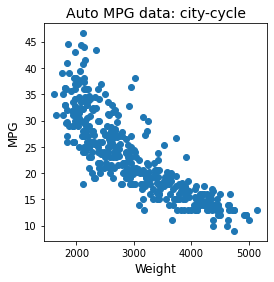

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(weight, mpg, 'o')
plt.xlabel("Weight", fontsize=12)
plt.ylabel("MPG", fontsize=12)
plt.title("Auto MPG data: city-cycle", fontsize=14)
plt.show()

A quick inspection of these data shows that it might be reasonable to use a polynomial function when performing the fit. For example, we can try a quadratic function like this:

$$
y(x) = \theta_0x_0 + \theta_1 x_1 + \theta_2 x_1^2 \,,
$$

where, as usual, $x_0$ is always equal to $1$, the target variable $y$ represents the MPG values, and the feature variable $x$ represents the weight values. Note that the resulting function is linear in $\theta_0$, $\theta_1$, and $\theta_2$. This means that if we treat the $x_1^2$ values as a new feature, we can still use the linear regression machinery to solve this problem. It is very important to understand that linear regression is linear in a sense that the function used to perform the fit contains only first powers of the $\theta$-parameters; it does not have to be a linear function of the features!

In sklearn creating new polynomial features can be done with the help of `Polynomialfeatures` class as demonstrated below.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

lr_poly = LinearRegression()#SGDRegressor()
std_sc = StandardScaler()
poly = PolynomialFeatures(degree=2, include_bias=False)

y = mpg
X_sc = std_sc.fit_transform(weight.reshape(-1, 1))
X_poly = poly.fit_transform(X_sc)
print(f"The shape of X_poly is {X_poly.shape}.")
lr_poly.fit(X_poly, y)

print(lr_poly.coef_)
print(lr_poly.intercept_)

The shape of X_poly is (398, 2).
[-7.14233283  1.22789878]
22.286674088282652


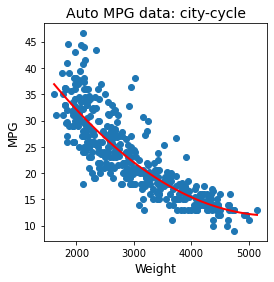

In [ ]:
plt.figure(figsize=(4, 4))
x = np.linspace(weight.min(), weight.max(), 100).reshape(-1, 1)
x_sc = std_sc.transform(x)
x_poly = poly.transform(x_sc)
y = lr_poly.predict(x_poly)
plt.plot(weight, mpg, 'o')
plt.plot(x, y, color='red', linewidth=2)
plt.xlabel("Weight", fontsize=12)
plt.ylabel("MPG", fontsize=12)
plt.title("Auto MPG data: city-cycle", fontsize=14)
plt.show()